# Airline

In [1]:
# Compatibility layer between Python 2 and Python 3
from __future__ import print_function
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.utils import np_utils

# %%
#Normalization  
def feature_normalize(train):
    train_norm = train.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))  #標準化(介於0~1之間)
    return train_norm


## 很重要  切割視窗
def create_segments_and_labels(df, time_steps, step):

    N_FEATURES = 1
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps-1, step):
        xs = df.values[i: i + time_steps]
        rate = (df.values[i + time_steps]-df.values[i + time_steps-1])/df.values[i + time_steps-1]
        #rate = df.values[i + time_steps]-df.values[i + time_steps-1]
        temp = rate
        if temp < 0:
            if temp <= -0.2:
                label =0
            elif temp <= -0.1:
                label =1
            elif temp < 0:
                label =2
        else:
            if temp == 0:
                label =3
            elif temp <= 0.1:
                label =4
            elif temp <= 0.2:
                label =5                
            elif temp >0.2:
                label =6              
 
        segments.append([xs])
        labels.append([label])

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

# ------- THE PROGRAM TO LOAD DATA AND TRAIN THE MODEL -------

# The number of steps within one time segment
TIME_PERIODS = 12
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 1

# %%

print("\n--- Load, inspect and transform data ---\n")

# Load data set containing all the data from csv
df = pd.read_csv('D:/Value of Dream/108-1 深度學習/Deep Learning Tool/Data/airline.csv',encoding='Big5')    #編碼為Big5
cols=['passenger']       #命名欄位
df =df[cols]                                      #將欄位名稱放入資料中          


# %%

print("\n--- Reshape the data into segments ---\n")

# Normalize features for training data set
df_train= feature_normalize(df)

x_train, y_train = create_segments_and_labels(df_train, TIME_PERIODS, STEP_DISTANCE)


Using TensorFlow backend.



--- Load, inspect and transform data ---


--- Reshape the data into segments ---



In [5]:
x_train#, y_train

131

In [2]:
# %%

print("\n--- Reshape data to be accepted by Keras ---\n")

# Inspect x data
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')

print('y_train shape: ', y_train.shape)

# Set input & output dimensions
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = 7


# Set input_shape / reshape for Keras
input_shape = (num_time_periods*num_sensors)   
x_train = x_train.reshape(x_train.shape[0], input_shape)   

print('x_train shape:', x_train.shape)
print('input_shape:', input_shape)

# Convert type for Keras otherwise Keras cannot process the data
x_train = x_train.astype("float32")
y_train = y_train.astype("float32")

# %%

# One-hot encoding of y_train labels (only execute once!)
y_train_oneshot = np_utils.to_categorical(y_train, num_classes)


## 分成訓練跟測試
x_train_used = x_train[0:120,]
y_train_used_oneshot = y_train_oneshot[0:120,]
x_test_used = x_train[121:,]
y_test_used_oneshot = y_train_oneshot[121:,]

print("\n--- Create neural network model ---\n")


## 注意注意注意!!
## SimpleRNN  的輸入格式 一筆資料格式是 (12,1)
## 整個格式要改成 (120, 12,1)  最前面120是資料筆數!!
## 所以  下面程式要加一個維度  擺放資料!!


# from 2 dimmension to 3 dimension

#(120,12)(120,12,1)     
x_train_used = x_train_used[:,:,np.newaxis]
x_test_used = x_test_used[:,:,np.newaxis]




--- Reshape data to be accepted by Keras ---

x_train shape:  (131, 12, 1)
131 training samples
y_train shape:  (131, 1)
x_train shape: (131, 12)
input_shape: 12

--- Create neural network model ---



In [3]:
#一對一模型
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers import SimpleRNN, Activation, Dense, RNN
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline

## build one To One Model(shape):
model = Sequential()
##  SimpleRNN  注意他的 input 格式!!(先變成三維，把第二維、三維放在這邊)
model.add(SimpleRNN(units=128, input_shape=(x_train_used.shape[1], x_train_used.shape[2])))
#units隱藏層神經元個數
#model.add(SimpleRNN(128, input_shape = (1, 12), activation = 'relu'))

model.add(Dropout(0.1))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(16, activation = 'relu'))#三層隱藏層
model.add(Dropout(0.1))
model.add(Dense(num_classes, activation='softmax'))
#num_classes不能改
model.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])
model.summary()

print("\n--- Fit the model ---\n")

train_history = model.fit(x=x_train_used, y= y_train_used_oneshot, validation_split=0.1, epochs=550, batch_size=10, verbose=2)


print("\n--- Learning curve of model training ---\n")

get_ipython().magic('matplotlib inline')


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 128)               16640     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_3 (Dropout)  

Epoch 72/550
 - 0s - loss: 0.8355 - acc: 0.6852 - val_loss: 0.6335 - val_acc: 0.7500
Epoch 73/550
 - 0s - loss: 0.7343 - acc: 0.7130 - val_loss: 0.7211 - val_acc: 0.6667
Epoch 74/550
 - 0s - loss: 0.8639 - acc: 0.6852 - val_loss: 0.6012 - val_acc: 0.7500
Epoch 75/550
 - 0s - loss: 0.7802 - acc: 0.6759 - val_loss: 0.6066 - val_acc: 0.7500
Epoch 76/550
 - 0s - loss: 0.7989 - acc: 0.7037 - val_loss: 0.5997 - val_acc: 0.7500
Epoch 77/550
 - 0s - loss: 0.8554 - acc: 0.6944 - val_loss: 0.5878 - val_acc: 0.7500
Epoch 78/550
 - 0s - loss: 1.0351 - acc: 0.5741 - val_loss: 1.2918 - val_acc: 0.5000
Epoch 79/550
 - 0s - loss: 1.0365 - acc: 0.5741 - val_loss: 0.6539 - val_acc: 0.6667
Epoch 80/550
 - 0s - loss: 0.7765 - acc: 0.6944 - val_loss: 0.5945 - val_acc: 0.7500
Epoch 81/550
 - 0s - loss: 0.7291 - acc: 0.6944 - val_loss: 0.7651 - val_acc: 0.6667
Epoch 82/550
 - 0s - loss: 0.7271 - acc: 0.6944 - val_loss: 0.7038 - val_acc: 0.6667
Epoch 83/550
 - 0s - loss: 0.7801 - acc: 0.6944 - val_loss: 0.568

Epoch 168/550
 - 0s - loss: 0.4012 - acc: 0.8056 - val_loss: 0.5557 - val_acc: 0.7500
Epoch 169/550
 - 0s - loss: 0.4402 - acc: 0.8241 - val_loss: 0.7124 - val_acc: 0.5833
Epoch 170/550
 - 0s - loss: 0.4285 - acc: 0.8056 - val_loss: 0.3596 - val_acc: 0.8333
Epoch 171/550
 - 0s - loss: 0.5490 - acc: 0.7963 - val_loss: 0.9325 - val_acc: 0.5833
Epoch 172/550
 - 0s - loss: 0.6599 - acc: 0.7315 - val_loss: 0.5728 - val_acc: 0.8333
Epoch 173/550
 - 0s - loss: 0.5982 - acc: 0.7407 - val_loss: 0.9608 - val_acc: 0.6667
Epoch 174/550
 - 0s - loss: 0.5113 - acc: 0.7870 - val_loss: 0.4822 - val_acc: 0.8333
Epoch 175/550
 - 0s - loss: 0.5016 - acc: 0.8056 - val_loss: 1.4050 - val_acc: 0.6667
Epoch 176/550
 - 0s - loss: 0.5406 - acc: 0.7963 - val_loss: 0.5704 - val_acc: 0.6667
Epoch 177/550
 - 0s - loss: 0.4576 - acc: 0.7963 - val_loss: 0.4070 - val_acc: 0.6667
Epoch 178/550
 - 0s - loss: 0.5553 - acc: 0.7870 - val_loss: 2.6920 - val_acc: 0.5833
Epoch 179/550
 - 0s - loss: 0.4565 - acc: 0.8519 - val

Epoch 264/550
 - 0s - loss: 0.2214 - acc: 0.9352 - val_loss: 0.4169 - val_acc: 0.8333
Epoch 265/550
 - 0s - loss: 0.2207 - acc: 0.9074 - val_loss: 0.5478 - val_acc: 0.7500
Epoch 266/550
 - 0s - loss: 0.2716 - acc: 0.9167 - val_loss: 0.4682 - val_acc: 0.8333
Epoch 267/550
 - 0s - loss: 0.2225 - acc: 0.9259 - val_loss: 0.6990 - val_acc: 0.6667
Epoch 268/550
 - 0s - loss: 0.3368 - acc: 0.8704 - val_loss: 0.5457 - val_acc: 0.8333
Epoch 269/550
 - 0s - loss: 0.2864 - acc: 0.8889 - val_loss: 0.5695 - val_acc: 0.8333
Epoch 270/550
 - 0s - loss: 0.3223 - acc: 0.8519 - val_loss: 0.5228 - val_acc: 0.8333
Epoch 271/550
 - 0s - loss: 0.2393 - acc: 0.8889 - val_loss: 0.3602 - val_acc: 0.8333
Epoch 272/550
 - 0s - loss: 0.2341 - acc: 0.8981 - val_loss: 0.4865 - val_acc: 0.8333
Epoch 273/550
 - 0s - loss: 0.2656 - acc: 0.9352 - val_loss: 0.3708 - val_acc: 0.8333
Epoch 274/550
 - 0s - loss: 0.3201 - acc: 0.8426 - val_loss: 0.6776 - val_acc: 0.6667
Epoch 275/550
 - 0s - loss: 0.2728 - acc: 0.9074 - val

Epoch 360/550
 - 0s - loss: 0.1939 - acc: 0.9259 - val_loss: 0.6893 - val_acc: 0.8333
Epoch 361/550
 - 0s - loss: 0.2262 - acc: 0.9167 - val_loss: 0.4263 - val_acc: 0.8333
Epoch 362/550
 - 0s - loss: 0.1526 - acc: 0.9352 - val_loss: 0.8877 - val_acc: 0.7500
Epoch 363/550
 - 0s - loss: 0.2006 - acc: 0.9074 - val_loss: 0.8790 - val_acc: 0.8333
Epoch 364/550
 - 0s - loss: 0.2098 - acc: 0.9444 - val_loss: 1.3502 - val_acc: 0.6667
Epoch 365/550
 - 0s - loss: 0.1611 - acc: 0.9537 - val_loss: 1.0950 - val_acc: 0.7500
Epoch 366/550
 - 0s - loss: 0.2149 - acc: 0.9259 - val_loss: 1.3452 - val_acc: 0.6667
Epoch 367/550
 - 0s - loss: 0.1654 - acc: 0.9352 - val_loss: 0.3845 - val_acc: 0.8333
Epoch 368/550
 - 0s - loss: 0.3307 - acc: 0.8796 - val_loss: 0.5741 - val_acc: 0.8333
Epoch 369/550
 - 0s - loss: 0.2099 - acc: 0.9352 - val_loss: 0.6453 - val_acc: 0.8333
Epoch 370/550
 - 0s - loss: 0.3402 - acc: 0.8519 - val_loss: 1.6069 - val_acc: 0.6667
Epoch 371/550
 - 0s - loss: 0.2788 - acc: 0.8981 - val

Epoch 456/550
 - 0s - loss: 0.1539 - acc: 0.9352 - val_loss: 1.2652 - val_acc: 0.8333
Epoch 457/550
 - 0s - loss: 0.1172 - acc: 0.9537 - val_loss: 1.0815 - val_acc: 0.8333
Epoch 458/550
 - 0s - loss: 0.1887 - acc: 0.9630 - val_loss: 1.1805 - val_acc: 0.8333
Epoch 459/550
 - 0s - loss: 0.1607 - acc: 0.9537 - val_loss: 1.1054 - val_acc: 0.8333
Epoch 460/550
 - 0s - loss: 0.1131 - acc: 0.9537 - val_loss: 1.0879 - val_acc: 0.8333
Epoch 461/550
 - 0s - loss: 0.1047 - acc: 0.9722 - val_loss: 1.1625 - val_acc: 0.8333
Epoch 462/550
 - 0s - loss: 0.0924 - acc: 0.9907 - val_loss: 1.1885 - val_acc: 0.8333
Epoch 463/550
 - 0s - loss: 0.1202 - acc: 0.9444 - val_loss: 1.0553 - val_acc: 0.8333
Epoch 464/550
 - 0s - loss: 0.1349 - acc: 0.9444 - val_loss: 1.1119 - val_acc: 0.8333
Epoch 465/550
 - 0s - loss: 0.1144 - acc: 0.9537 - val_loss: 1.2552 - val_acc: 0.8333
Epoch 466/550
 - 0s - loss: 0.1123 - acc: 0.9722 - val_loss: 1.3107 - val_acc: 0.8333
Epoch 467/550
 - 0s - loss: 0.1335 - acc: 0.9537 - val

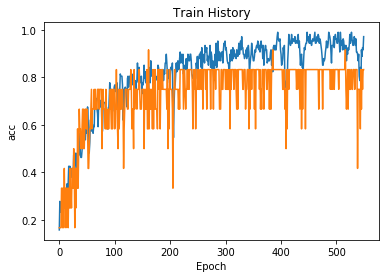

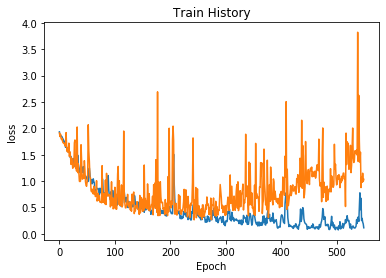

10/10 [==============================] - 0s 100us/step
Accuracy: 0.4000000059604645%


array([[0, 0, 0, 0, 0, 0],
       [1, 2, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 1],
       [0, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 1, 0]], dtype=int64)

In [6]:
import matplotlib.pyplot as plt
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title("Train History")
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.show()

show_train_history(train_history, "acc", "val_acc") ## 訓練正確率圖

show_train_history(train_history, "loss", "val_loss") ## 訓練誤差圖

###############################


scores = model.evaluate(x_test_used, y_test_used_oneshot)

print("Accuracy: {}%".format(scores[1]))


results = model.predict_classes(x_test_used)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train[121:,], results)
cm
